In [1]:
import os
import json
import hydra
import torch
import peano
import transformers
import io
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import worker
from proofsearch import TreeSearchNode, make_agent

/network/scratch/m/moksh.jain/minimo_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(os.path.join('theories', "groups" + '.p')) as f:
    theory = f.read()

premises = ['op_assoc', 'op_comm', 'id_l', 'inv_l', 'eq_refl', 'eq_symm', 'rewrite']

d = peano.PyDerivation()
d.incorporate(theory)
proven_conjectures = []
seen_hindsight_goals = set()
proofs = []
outcomes = []

In [3]:


continue_dir = "/network/scratch/m/moksh.jain/minimo_experiments/repro"
start_iteration = 0
agents = []
if continue_dir is not None:
    curr_dir = os.getcwd()
    os.chdir(continue_dir)
    print('Continuing run from', continue_dir)
    # Find largest iteration number such that i.pt exists.
    i = 0
    while os.path.exists(f'{i}.pt'):
        agents.append(torch.load(f'{i}.pt'))
        print('Loaded agent from', f'{i}.pt')
        i += 1
    i -= 1
    # Load examples and outcomes.
    if i > 0:
        with open(f'outcomes_{i}.json', 'r') as f:
            outcomes = json.load(f)
            print('Loaded outcomes from', f'outcomes_{i}.json')

    examples = [(o["problem"], o["logprob"]) for o in outcomes if o["logprob"] is not None]
    successful_outcomes = [o for o in outcomes if o["logprob"] is not None]
    os.chdir(curr_dir)

Continuing run from /network/scratch/m/moksh.jain/minimo_experiments/repro


/tmp/ipykernel_4060301/375189233.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agents.append(torch.load(f'{i}.pt'))


Loaded agent from 0.pt


/tmp/ipykernel_4060301/375189233.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agents.append(torch.load(f'{i}.pt'))


Loaded agent from 1.pt
Loaded agent from 2.pt
Loaded agent from 3.pt
Loaded agent from 4.pt
Loaded outcomes from outcomes_4.json


In [4]:
agents

In [5]:
successful_outcomes

[{'iteration': 0,
  'problem': '(= id id)',
  'proof': ['theorem t : (= id id) {', 'show (= id id) by eq_refl.', '}'],
  'logprob': -2.6204863242531777,
  'actions': ['c eq_refl', '=> (= id id).'],
  'hindsight': False},
 {'iteration': 0,
  'problem': "[('a0 : G) -> (= 'a0 'a0)]",
  'proof': ["theorem t : [('a0 : G) -> (= 'a0 'a0)] {",
   'intro x : G.',
   'show (= x x) by eq_refl.',
   '}'],
  'logprob': -4.97331985335439,
  'actions': ['intro.', 'c eq_refl', '=> (= x x).'],
  'hindsight': False},
 {'iteration': 0,
  'problem': "[('a0 : prop) -> (= id id)]",
  'proof': ["theorem t : [('a0 : prop) -> (= id id)] {",
   'show (= id id) by eq_refl.',
   "intro _ : [('a0 : prop) -> (= id id)].",
   '}'],
  'logprob': -4.424689471892771,
  'actions': ['c eq_refl', '=> (= id id).', 'intro.'],
  'hindsight': False},
 {'iteration': 0,
  'problem': "[('a0 : prop) -> ('a1 : 'a0) -> 'a0]",
  'proof': ["theorem t : [('a0 : prop) -> ('a1 : 'a0) -> 'a0] {",
   'intro x : prop.',
   "intro _ : [('a1

In [6]:
def recompute_logprobs(agent, examples, theory, iter):
    for example in examples:
        if example["iteration"] > iter:
            continue
        state = peano.PyProofState(theory.theory,
                               theory.premises,
                               example["problem"])
        
        root = TreeSearchNode(agent._node_type([state]))
        
        action_strs = example["actions"]
        actions = []
        current = root

        for action in action_strs:
            current.expand()
            for i, ac in enumerate(current.actions):
                if str(ac) == action:
                    actions.append(ac)
                    current = current.children()[i]
                    break
        
        logprob = root.solution_logprob_under_policy(agent._policy, actions)
        if iter == example["iteration"]:
            assert logprob == example["logprob"]
        example[f"logprob_iter_{iter}"] = logprob
    return examples

In [7]:
for i, agent in enumerate(agents):
    successful_outcomes = recompute_logprobs(agent, successful_outcomes, worker.BackgroundTheory(theory, premises), i)

In [13]:
i0_examples = [example for example in successful_outcomes if example["iteration"] == 0]
lps = list()
for i in range(len(agents)):
    lps.append(np.array([example[f"logprob_iter_{i}"] for example in i0_examples]))

In [9]:
len(lps)

5

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Logprobs of Conjectures at Iteration 0')

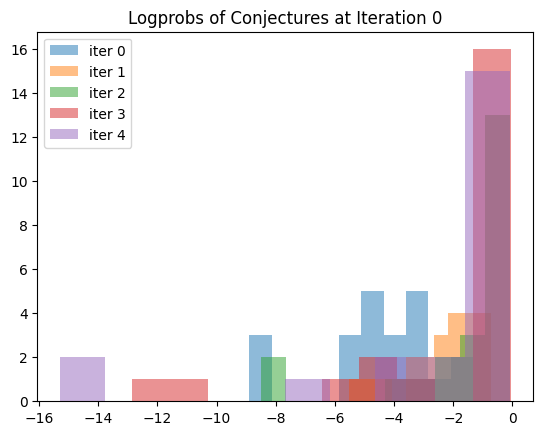

In [11]:
figure, axes = plt.subplots(1, 1)

axes.hist(lps[0], alpha=0.5, label='iter 0')
axes.hist(lps[1], alpha=0.5, label='iter 1')
axes.hist(lps[2], alpha=0.5, label='iter 2')
axes.hist(lps[3], alpha=0.5, label='iter 3')
axes.hist(lps[4], alpha=0.5, label='iter 4')

axes.legend()
axes.set_title('Logprobs of Conjectures at Iteration 0')

# plt.hist(lps[0])

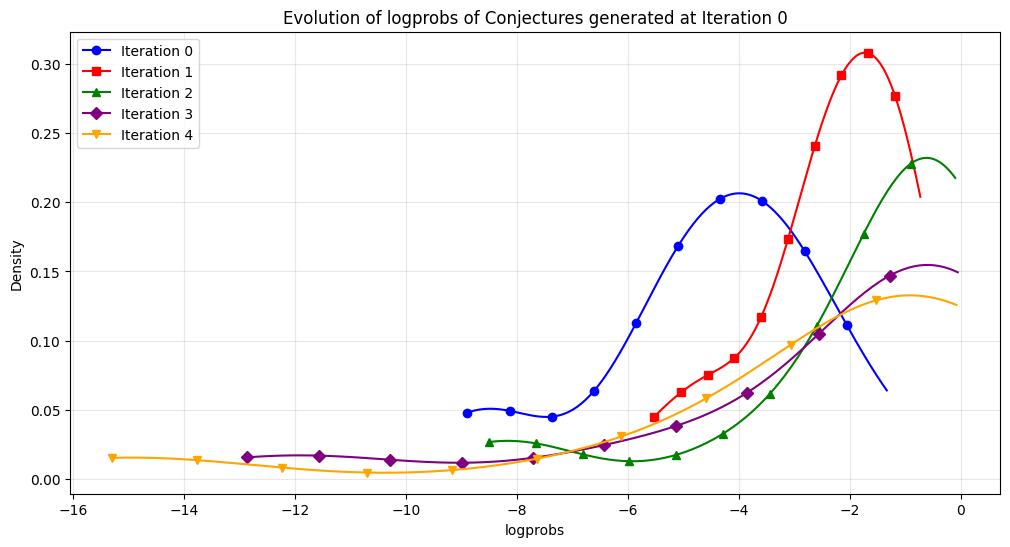

In [17]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(12, 6))

# Define colors for each array
colors = ['blue', 'red', 'green', 'purple', 'orange']
markers = ['o', 's', '^', 'D', 'v']

# Plot density for each array
for i, arr in enumerate(lps):
    kde = gaussian_kde(arr)
    
    x_range = np.linspace(arr.min(), arr.max(), 200)
    
    plt.plot(x_range, kde(x_range), color=colors[i], marker=markers[i], markevery=20, label=f'Iteration {i}')

plt.title('Evolution of logprobs of Conjectures generated at Iteration 0')
plt.xlabel('logprobs')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()